My plan is to create a bot that parses the last major news articles of a given keyword in order to generate a summary of each article in a few seconds followed by a sentiment analysis.

This is informative and useful to anyone as a trader/investor when considering recent stocks or crypto news!

You can also use it for fun or out of curiosity for any given keyword of your interest!

The flow of the bot:
1_Extract => 2_Summarize => 3_Analyze => 4_Generate graphs about sentiment & polarity

1_We extract the articles from Google news with the Google News python package.

2_We summarize each article using Newspaper Python Package

3_Run sentiment analysis on each summary with the help of VADER.

4_Generate a 24H sentiment graph & polarity scatterplot.

In [14]:
#Uncomment the lines below to install the required packages:

# !pip install GoogleNews
# !pip install nltk
# !pip install newspaper3k
# !pip install wordcloud

In [15]:
#Importing Libraries

from nltk.sentiment.vader import SentimentIntensityAnalyzer
from GoogleNews import GoogleNews
from newspaper import Article
from newspaper import Config
from wordcloud import WordCloud, STOPWORDS

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt

from textblob import TextBlob

import nltk
plt.style.use('seaborn-whitegrid')
%matplotlib inline

#Required for Sentiment Analysis
nltk.download('vader_lexicon')

from nltk.sentiment.vader import SentimentIntensityAnalyzer
#Loading analyzer
analyzer = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Fluffy\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


News Extraction.

In [16]:
#Defining the dates to be used in the GoogleNews Query in next cell
now = dt.date.today()
now = now.strftime('%m-%d-%Y')

yesterday = dt.date.today() - dt.timedelta(days = 1)
yesterday = yesterday.strftime('%m-%d-%Y')

nltk.download('punkt')
user_agent = 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10.15; rv:78.0) Gecko/20100101 Firefox/78.0'

config = Config()
config.browser_user_agent = user_agent
config.request_timeout = 10

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Fluffy\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Keep in mind that the Google News package fetches only the 10 most recent news, we will bypass this with a loop in order to extract all possible articles in the first 10 pages in Google News, it will gather between 30 to 70 articles on average.

In [17]:
keyword_interest = input("Please provide the name of the asset, stock or crypto of interest")
if keyword_interest != '':
    print(f'Extracting & Analyzing {keyword_interest}, it takes sometime!')
googlenews = GoogleNews(start = yesterday, end = now )
googlenews.search(keyword_interest)
googlenews.total_count()

result = googlenews.result()

#This loop is to bypass the limit of 10 articles
for i in range(2,8):
    googlenews.getpage(i)
    result=googlenews.result()
    df=pd.DataFrame(result)

#Storing Results in a pd DataFrame
list=[]
df = pd.DataFrame(result)
print(df)

Extracting & Analyzing fomc, it takes sometime!
                                                title  \
0   Breaking: FOMC Minutes sink the US dollar a to...   
1   US Dollar Down, Vol Down, Stocks Up After May ...   
2   FOMC Minutes Preview: Another Market Rugpull F...   
3           Oil consolidates, gold dips ahead of FOMC   
4   Gold, silver see price declines ahead of FOMC ...   
..                                                ...   
65  Fed minutes confirm half-point hike expectatio...   
66  Podcast : Financial Market Preview - Wednesday...   
67  SGX Nifty indicates a higher opening of about ...   
68  Asian Stock Market: Modest gains on positive c...   
69                  Pound Sterling Jumps Unexpectedly   

                              media         date                   datetime  \
0                          FXStreet  2 hours ago 2022-05-26 10:04:56.716814   
1                           DailyFX  1 hours ago 2022-05-26 11:04:56.720764   
2                     Forex Fa

Article Summarizing, be patient could take more than 2 minutes to run!!!

In [18]:
try:
    list = []
    for i in df.index:
        #Empty dictionary to append each article in each iteration
        dict = {}
        article = Article(df['link'][i], config = config)
        try:
            article.download()
            article.parse()
            article.nlp()
        except:
            pass
        dict['Date'] = df['date'][i]
        dict['Media'] = df['media'][i]
        dict['Title'] = article.title
        dict['Article'] = article.text
        dict['Summary'] = article.summary
        dict['Key_words'] = article.keywords

        dict['datetime'] = df['datetime'][i]
        
        list.append(dict)
    check_empty = not any(list)

    if check_empty == False:
        news_DF = pd.DataFrame(list)
        print(news_DF)

except Exception as e:
    print("There is an exception:"+ str(e))
    print("There are some issues in retrieving the date. Try again or enter a different keyword of interest!")

           Date                            Media  \
0   2 hours ago                         FXStreet   
1   1 hours ago                          DailyFX   
2   3 hours ago                    Forex Factory   
3     1 day ago                      MarketPulse   
4     1 day ago                            KITCO   
..          ...                              ...   
65  9 hours ago                      MarketPulse   
66    1 day ago             Investing.com Canada   
67  3 hours ago  Dalal Street Investment Journal   
68  1 hours ago                         FXStreet   
69  8 hours ago                    Investing.com   

                                                Title  \
0   Breaking: FOMC Minutes sink the US dollar a to...   
1   US Dollar Down, Vol Down, Stocks Up After May ...   
2                                                       
3   Oil consolidates, gold dips ahead of FOMC - Ma...   
4   Gold, silver see price declines ahead of FOMC ...   
..                               

In [19]:
#Change Columns order
news_DF = news_DF[['datetime', 'Media', 'Title', 'Article', 'Summary', 'Date', 'Key_words']]

#Taking a look at our dataframe so far
news_DF.head()


,datetime,Media,Title,Article,Summary,Date,Key_words
0,2022-05-26 10:04:56.716814,FXStreet,Breaking: FOMC Minutes sink the US dollar a to...,The Federal Open Market Committee minutes have...,The Federal Open Market Committee minutes have...,2 hours ago,"[rate, policy, minutes, fomc, dollar, sink, ri..."
1,2022-05-26 11:04:56.720764,DailyFX,"US Dollar Down, Vol Down, Stocks Up After May ...",Advertisement\n\nUS Dollar Outlook:\n\nNo surp...,AdvertisementUS Dollar Outlook:No surprises fr...,1 hours ago,"[index, policy, yy, dollar, minutes, market, i..."
2,2022-05-26 09:04:56.723754,Forex Factory,,,,3 hours ago,[]
3,2022-05-25 12:04:56.745727,MarketPulse,"Oil consolidates, gold dips ahead of FOMC - Ma...",Risks remain tilted to the upside in oil\n\nOi...,Risks remain tilted to the upside in oilOil pr...,1 day ago,"[ahead, trading, tilted, small, dips, usd, rem..."
4,2022-05-25 12:04:56.767010,KITCO,"Gold, silver see price declines ahead of FOMC ...","Editor's Note: With so much market volatility,...",(Kitco News) - Gold and silver prices are lowe...,1 day ago,"[ahead, futures, trading, support, minutes, te..."


In [20]:
vader = SentimentIntensityAnalyzer()

#Columns Date, Media Title Article Summary Key_words
#Iterating through the summary to generate polarity sores with Vader
scores = news_DF['Title'].apply(vader.polarity_scores).tolist()
scores_df = pd.DataFrame(scores)

news_DF = news_DF.join(scores_df, rsuffix='right')

news_DF.head()


,datetime,Media,Title,Article,Summary,Date,Key_words,neg,neu,pos,compound
0,2022-05-26 10:04:56.716814,FXStreet,Breaking: FOMC Minutes sink the US dollar a to...,The Federal Open Market Committee minutes have...,The Federal Open Market Committee minutes have...,2 hours ago,"[rate, policy, minutes, fomc, dollar, sink, ri...",0.0,0.885,0.115,0.2057
1,2022-05-26 11:04:56.720764,DailyFX,"US Dollar Down, Vol Down, Stocks Up After May ...",Advertisement\n\nUS Dollar Outlook:\n\nNo surp...,AdvertisementUS Dollar Outlook:No surprises fr...,1 hours ago,"[index, policy, yy, dollar, minutes, market, i...",0.0,1.000,0.000,0.0000
2,2022-05-26 09:04:56.723754,Forex Factory,,,,3 hours ago,[],0.0,0.000,0.000,0.0000
3,2022-05-25 12:04:56.745727,MarketPulse,"Oil consolidates, gold dips ahead of FOMC - Ma...",Risks remain tilted to the upside in oil\n\nOi...,Risks remain tilted to the upside in oilOil pr...,1 day ago,"[ahead, trading, tilted, small, dips, usd, rem...",0.0,1.000,0.000,0.0000
4,2022-05-25 12:04:56.767010,KITCO,"Gold, silver see price declines ahead of FOMC ...","Editor's Note: With so much market volatility,...",(Kitco News) - Gold and silver prices are lowe...,1 day ago,"[ahead, futures, trading, support, minutes, te...",0.0,1.000,0.000,0.0000


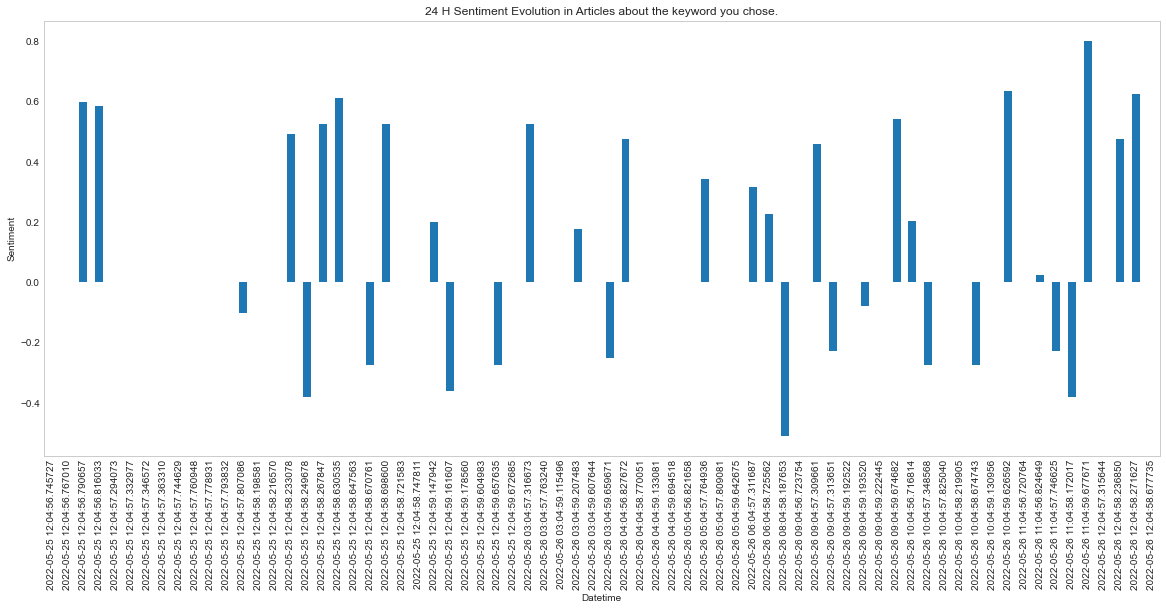

In [21]:
from pandas import tseries

plt.rcParams['figure.figsize'] = [20, 8]
mean_scores = news_DF.groupby(['datetime']).mean()

mean_scores = mean_scores.unstack()

mean_scores = mean_scores.xs('compound').transpose()
mean_scores.plot(kind = 'bar')
plt.xlabel('Datetime')
plt.ylabel('Sentiment')
plt.title('24 H Sentiment Evolution in Articles about the keyword you chose.')

plt.grid()

Subjectivity

In [22]:
def getSubjectivity(text):
    return TextBlob(text).sentiment.subjectivity

def getPolarity(text):
    return TextBlob(text).sentiment.polarity

#Create 2 columns
news_DF['Subjectivity'] = news_DF['Summary'].apply(getSubjectivity)
news_DF['Polarity'] = news_DF['Summary'].apply(getPolarity)
news_DF.drop(['Key_words', 'Media'], axis=1, inplace= True)

#Preview the DF with Subjectivity &  Polarity columns
news_DF.head(3)

,datetime,Title,Article,Summary,Date,neg,neu,pos,compound,Subjectivity,Polarity
0,2022-05-26 10:04:56.716814,Breaking: FOMC Minutes sink the US dollar a to...,The Federal Open Market Committee minutes have...,The Federal Open Market Committee minutes have...,2 hours ago,0.0,0.885,0.115,0.2057,0.584938,0.219276
1,2022-05-26 11:04:56.720764,"US Dollar Down, Vol Down, Stocks Up After May ...",Advertisement\n\nUS Dollar Outlook:\n\nNo surp...,AdvertisementUS Dollar Outlook:No surprises fr...,1 hours ago,0.0,1.000,0.000,0.0000,0.346667,0.146667
2,2022-05-26 09:04:56.723754,,,,3 hours ago,0.0,0.000,0.000,0.0000,0.000000,0.000000


Computing Negative, Neutral & Positive Analysis

In [23]:
 def getAnalysis(score):
    if score < 0:
        return 'Negative'
    elif score == 0 :
        return 'Neutral'
    else:
        return 'Positive'

#Adding Analysis column to our DF
news_DF['Analysis'] = news_DF['Polarity'].apply(getAnalysis)
news_DF.head(3)

,datetime,Title,Article,Summary,Date,neg,neu,pos,compound,Subjectivity,Polarity,Analysis
0,2022-05-26 10:04:56.716814,Breaking: FOMC Minutes sink the US dollar a to...,The Federal Open Market Committee minutes have...,The Federal Open Market Committee minutes have...,2 hours ago,0.0,0.885,0.115,0.2057,0.584938,0.219276,Positive
1,2022-05-26 11:04:56.720764,"US Dollar Down, Vol Down, Stocks Up After May ...",Advertisement\n\nUS Dollar Outlook:\n\nNo surp...,AdvertisementUS Dollar Outlook:No surprises fr...,1 hours ago,0.0,1.000,0.000,0.0000,0.346667,0.146667,Positive
2,2022-05-26 09:04:56.723754,,,,3 hours ago,0.0,0.000,0.000,0.0000,0.000000,0.000000,Neutral


Plotting the Polarity & Subjectivity:
    When dots show big horizontal spread => there are big differences of opinion about the keyword of interest.
    When dots are clustered near 0.0 horizontally => same ideas are shared regarding the keyword of interest.

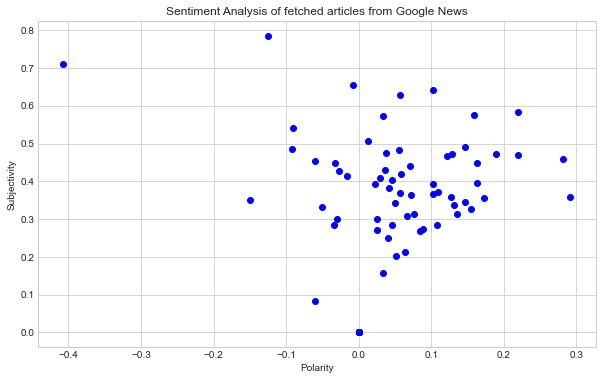

In [24]:
plt.figure(figsize=(10, 6))
for i in range(0, news_DF.shape[0]):
    plt.scatter(news_DF['Polarity'][i], news_DF['Subjectivity'][i], color = 'Blue')

plt.title('Sentiment Analysis of fetched articles from Google News')
plt.xlabel('Polarity')
plt.ylabel('Subjectivity')
plt.show()

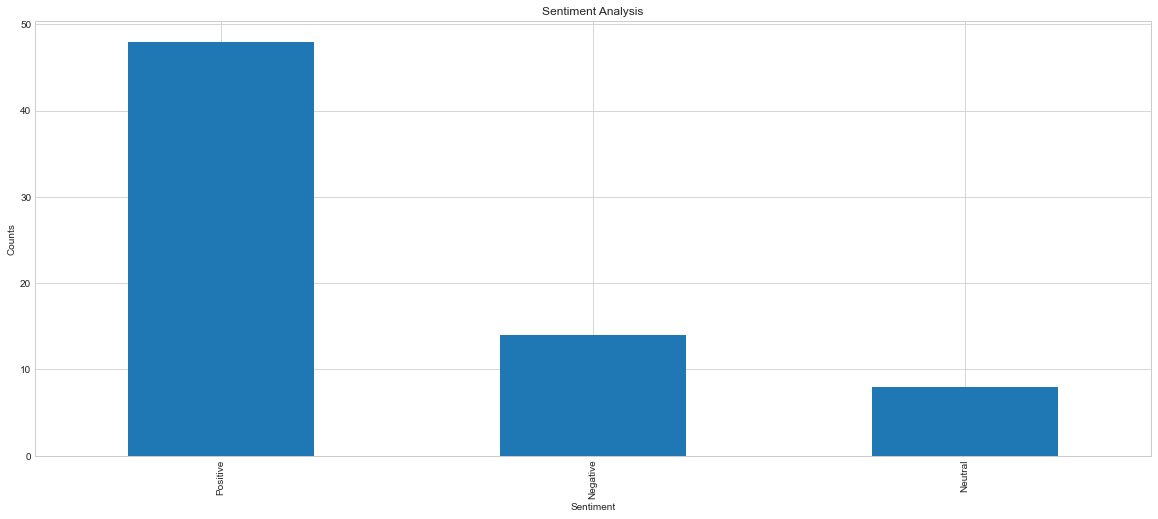

In [25]:
#Value Counts Positive, Negative, Neutral of Articles
news_DF['Analysis'].value_counts()

#Plot & Visualize the counts
plt.title('Sentiment Analysis')
plt.xlabel('Sentiment')
plt.ylabel('Counts')
news_DF['Analysis'].value_counts().plot(kind = 'bar')
plt.show()

WordCloud for fomc


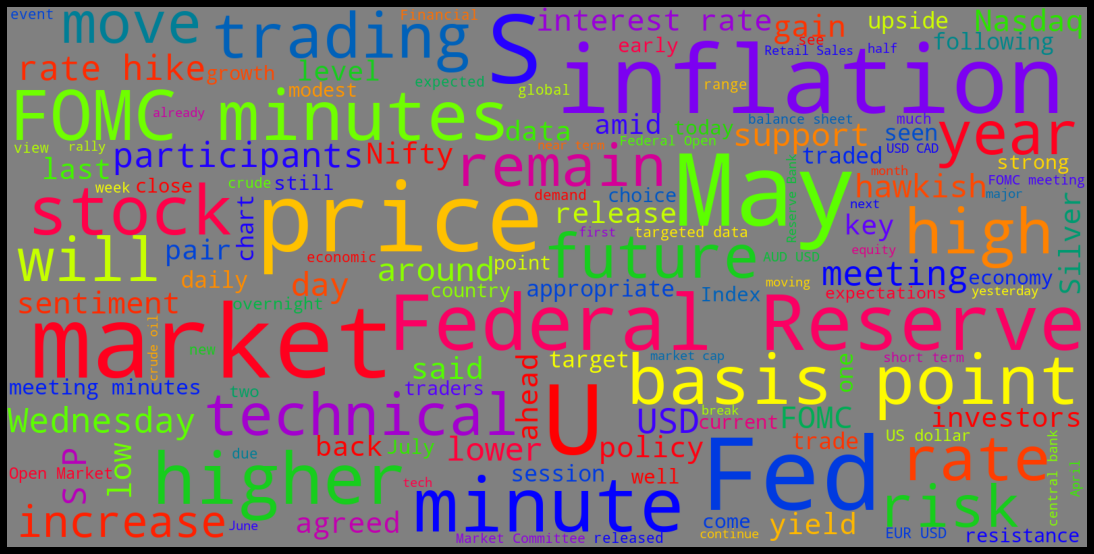

In [26]:
def cloud_words(text):
    stopwords = set(STOPWORDS)
    allWords = ' '.join([nws for nws in text])
    wordCloud = WordCloud(background_color = 'grey', width = 1600, height = 800, stopwords = stopwords, min_font_size= 18, max_font_size= 150, colormap= 'prism').generate(allWords)

    fig, ax = plt.subplots(figsize = (15,10), facecolor = 'k')
    plt.imshow(wordCloud)
    ax.axis("off")
    fig.tight_layout(pad = 0)
    plt.show()

print('WordCloud for ' + keyword_interest)
cloud_words(news_DF['Summary'].values)